<h3> Importing Libraries </h3>

In [474]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
torch.manual_seed(1)

<h3> Loading +/- Data </h3>

In [490]:
# Load positive and negative data sets as dataframe
positive_data = pd.read_csv('deep_annotator_data/positive_sample.txt', header=None, nrows=10000)
positive_data.columns = ["Gene"]
negative_data = pd.read_csv('deep_annotator_data/negative_sample.txt', header=None, nrows=10000)
negative_data.columns = ["Gene"]

<h3> Generate word IDs <h3>

In [491]:
strings = set()
window = 1
def allLexicographicRecur (string, data, last, index): 
    length = len(string)
    for i in range(length): 
        data[index] = string[i] 
        if index==last:
            res = ''.join(data)
            strings.add(res)
        else: 
            allLexicographicRecur(string, data, last, index+1) 
def allLexicographic(string, n): 
    length = len(string)
    data = [""] * (length+1)
    string = sorted(string) 
    allLexicographicRecur(string, data, window-1, 0)
string = "01234"
allLexicographic(string, window)
strings = sorted(strings)
vocabulary = {}
for val, i in enumerate(strings):
    vocabulary[i] = val
# print(word_ids)

<h3> Generate Word Embeddings </h3>

In [492]:
embeds = nn.Embedding(len(vocabulary), 5)
embeddings = {}
for word in vocabulary:
    embeddings[word] = embeds(torch.tensor(vocabulary[word], dtype=torch.long))

In [493]:
def generate_samples(data_sample):
    list_of_tensors = []
    for data in data_sample.itertuples():
        for i in range(len(data.Gene) - window + 1):
            if i == 0:
                first_tensor = embeddings[data.Gene[i:i+window]]
            else:
                first_tensor = torch.cat((first_tensor, embeddings[data.Gene[i:i+window]]), 0)
        list_of_tensors.append(first_tensor)
    trainpositives = torch.stack(list_of_tensors)
    return trainpositives

positives = generate_samples(positive_data)
negatives = generate_samples(negative_data)
data_ = torch.cat([positives, negatives], dim=0)

negative_labels = torch.zeros(negatives.shape[0], 1)
positive_labels = torch.ones(positives.shape[0], 1)
labels_ = torch.cat([positive_labels, negative_labels], dim=0)

In [494]:
labels_.shape

torch.Size([20000, 1])

<h3> FC Layer </h3>

In [496]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(505, 505)
        self.relu1 = nn.Sigmoid()
        self.fc2 = nn.Linear(505, 100)
        self.prelu = nn.Sigmoid()
        self.out = nn.Linear(100, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        a1 = self.fc1(x)
        h1 = self.relu1(a1)
        #dout = self.dout(h1)
        a2 = self.fc2(h1)
        h2 = self.prelu(a2)
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y
net = Net()

In [497]:
opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = nn.BCELoss()

In [498]:
def train_epoch(model, opt, criterion, batch_size=50):
    model.train()
    losses = []
    for beg_i in range(0, data_.size(0), batch_size):
        data_batch = data_[beg_i:beg_i + batch_size, :]
        labels_batch = labels_[beg_i:beg_i + batch_size, :]
        data_batch = autograd.Variable(data_batch)
        labels_batch = autograd.Variable(labels_batch)

        opt.zero_grad()
        # (1) Forward
        labels_hat = net(data_batch)
        # (2) Compute diff
        loss = criterion(labels_hat, labels_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()        
        losses.append(loss.data.numpy())
    loss = sum(losses)/len(losses)
    return loss

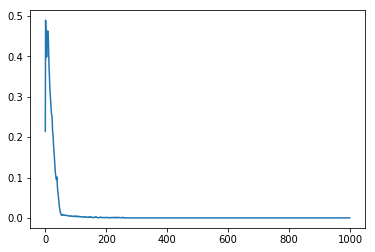

In [499]:
losses = []
epochs = 1000
for e in range(epochs):
    losses.append(train_epoch(net, opt, criterion))
plt.plot(losses)

In [ ]:
len(losses)